<a href="https://colab.research.google.com/github/thee-smarty/Camouflage-Military-Detection/blob/main/cmd-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!apt-get update && apt-get install -y python3-opencv
!pip install scikit-learn scipy matplotlib
!pip install -q tensorflow-addons
!pip install -q tensorflow-probability
!pip install -q opencv-python-headless
!pip install -q seaborn
!pip install -qU wandb
!pip install -qU scikit-learn
!pip install --upgrade tensorflow-addons
!pip install tensorflow-addons
!pip install tensorflow
!pip show tensorflow-addons
!pip install --upgrade tensorflow-addons
!pip install tensorflow-addons
!pip install tensorflow-probability
!pip install tensorflow-datasets
!python --version

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 229 kB in 2s (107 kB/s)
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-opencv is already the newest version (4.5.4+dfsg-9ubuntu4+jammy0).
0 upgraded, 0

In [ ]:
import tensorflow_addons as tfa
import tensorflow as tf
import os
import tensorflow_datasets as tfds
import tensorflow_probability as tfp

In [ ]:
def feature(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

In [ ]:
height = 512
width = 512
font_size = 20
def apply_visual_attention(path):
    img = cv2.imread(path, 0)
    return img

In [ ]:
import os
import cv2
import numpy as np

train_image_path = '/content/drive/MyDrive/dataset-splitm/Training/images/'
train_gt_path = '/content/drive/MyDrive/dataset-splitm/Training/GT/'
test_image_path = '/content/drive/MyDrive/dataset-splitm/Testing/images/'
test_gt_path = '/content/drive/MyDrive/dataset-splitm/Testing/GT/'

In [ ]:
img_size2=(512,512)

def load_data(image_path, gt_path,maxi):
    images = []
    gt_instances = []
    c=0
    for filename in sorted(os.listdir(image_path)):
        c+=1
        if(c>=maxi):
            break
        if(c%50==0):
            print(c)
        if filename.endswith('.jpg'):
            img=apply_visual_attention(image_path + filename)
            img = cv2.resize(img, img_size2)
            images.append(img)
            gt = cv2.imread(gt_path + filename[:-4] + '.png', cv2.IMREAD_GRAYSCALE)
            gt = cv2.resize(gt, img_size2, interpolation=cv2.INTER_LINEAR)
            gt_instances.append(gt)
    return np.array(images), np.array(gt_instances)

In [ ]:
train_images, train_gt_instances = load_data(train_image_path, train_gt_path,6000)
test_images, test_gt_instances = load_data(test_image_path, test_gt_path,2000)

print('done')

In [ ]:
strategy = tf.distribute.MirroredStrategy()

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
backend.clear_session()

def build_generator(input_shape):
    model = Sequential()
    # Encoder
    model.add(Conv2D(64, kernel_size=(3, 3), strides=(2, 2), input_shape=input_shape, padding='same', activation='relu'))
    model.add(Conv2D(128, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(Conv2D(256, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(Conv2D(512, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(Dropout(0.5))
    # Decoder
    model.add(Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu'))
    model.add(Conv2DTranspose(1, (3, 3), strides=(2, 2), padding='same', activation='sigmoid'))

    # Output
    model.add(Conv2D(1, (1, 1), activation='sigmoid'))
    return model

with strategy.scope():
    input_shape = (512,512,1)
    generator = build_generator(input_shape)

    # Define optimizer and loss function
    optimizer = tf.keras.optimizers.Adam(lr=0.001)
    loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

    # Compile the model
    generator.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy', tf.keras.metrics.Precision()])
    generator.summary()

In [ ]:
train_images[0].shape
train_gt_instances[0].shape
len(train_images)

In [ ]:
num_epochs = 50
batch_size = 64

# Train the model
history = generator.fit(train_images, train_gt_instances,epochs=num_epochs,batch_size=batch_size,validation_data=(test_images, test_gt_instances))

In [ ]:
generator.compile(optimizer='adam', loss='binary_crossentropy')

(1, 512, 512)
1/1 [==============================] - 0s 73ms/step


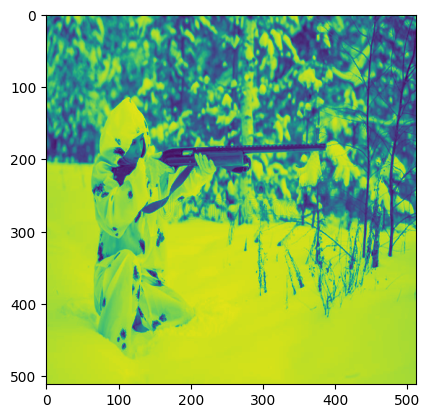

In [ ]:
import matplotlib.pyplot as plt
img_path='image.jpg'
otimg = cv2.imread(img_path)
otimg=apply_visual_attention(img_path)
timg = cv2.resize(otimg, img_size2)
plt.imshow(timg)
timg=np.array([timg])
print(timg.shape)
predictions = generator.predict(timg)

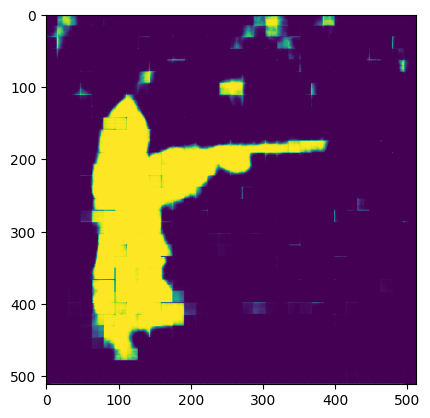

In [ ]:
plt.imshow(predictions[0])

/content/drive/MyDrive/dataset-split/Testing/GT/image529.png


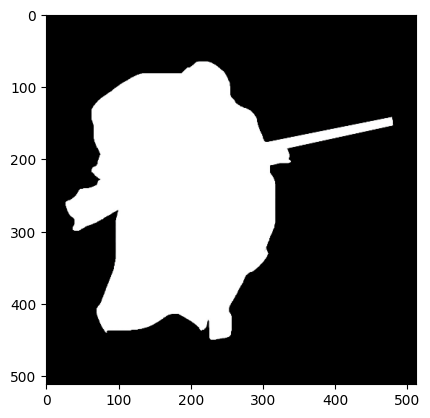

In [ ]:
timg= img_path.split('/')
timgp=timg.pop().split('.')
timgp=[timgp[0],'png']
timgp=".".join(timgp)
timg[6]='GT'
timg=timg+[timgp]
timg='/'.join(timg)
print(timg)
timg = cv2.resize(cv2.imread(timg), img_size2)
plt.imshow(timg)